In [1]:
import tripyview.sub_notebookheader as nb_setup
# which_matplotlib = 'inline' (default), 
#                    'notebook'(jupyter notebook), 
#                    'widget'(jupyterlab)
nb_setup.init_notebook(which_matplotlib="inline")
# centralized autoimport of: 
# import os
# import warnings
# import time as clock
# import numpy as np
# import xarray as xr
# import shapefile as shp
# import tripyview as tpv
# client, use_existing_client = None, "tcp://0.0.0.0:0000"

/albedo/home/pscholz/tripyview
 -> Warming up Numba neighborhood connectivity
 -> Warming up Numba grid kernel
 -> Warming up Numba kernels for vec_r2g
 -> Warming up Numba lsmask compute
 -> Warming up Numba smoothers


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [2]:
# parameters
#___Dask Client Parameters____________________________________________________________
do_papermill      = False
do_parallel       = True
parallel_nprc     = 64   # number of total processes
parallel_nthread  = 2    # number of threads per worker --> number worker = parallel_nprc/parallel_nthread
parallel_tmem     = 256  # max. available RAM

#___Mesh Path & Save Path_____________________________________________________________
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
# mesh_path         = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
mesh_path         = '/albedo/work/user/pscholz/mesh_fesom2.0/dart/'
# mesh_path         = '/work/ba1264/a270210/model/input/fesom2/dart/'

save_path         = None #'~/figures/test_papermill/'
save_fname        = None # filename from papermill come in through save_fname
tripyrun_name     = None # papermill workflow name of notebook 
tripyrun_analysis = None # papermill diagnostic driver
tripyrun_spath_nb = None # papermill path to processed notebooks
tripyrun_spath_fig= None # papermill path to processed figures

#___Data Path & Input Names___________________________________________________________
input_paths   = list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')
# input_paths.append('/work/ab0995/a270210/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/hist1950d/outdata/fesom/')
input_paths.append('/albedo/work/user/pscholz/results/dart_linfs_pc0_ctrl_1/1/')

input_names   = list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
# input_names.append('TKE')
input_names.append('dart test')

# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl    = None
do_allcycl= False
vname     = 'temp'
year      = [1958, 1961]
mon       = None
day       = None
record    = None 
box       = None
depth     = None

#___Define Reference Data, Year, Mon ...______________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None # '/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/'
ref_name  = None # 'TKE'
ref_year  = None #[1979, 2019]
ref_mon   = None
ref_day   = None
ref_record= None

#___Define Boxregion via shape file for index compuation______________________________
box_region = list()
box_region.append('global')
box_region.append('ocean_basins/Arctic_Basin.shp')
# box_region.append('ocean_basins/Eurasian_Basin.shp')
# box_region.append('mpas_region/Canada_Basin.shp')
# box_region.append('mpas_region/North_Atlantic_Ocean.shp')
# box_region.append('mpas_region/Greenland_Sea.shp')
# box_region.append('mpas_region/Irminger_Sea.shp')
# box_region.append('mpas_region/Norwegian_Sea.shp')
# box_region.append('mpas_region/Labrador_Sea.shp')
# box_region.append('mpas_region/North_Pacific_Ocean.shp')
# box_region.append('mpas_region/South_Pacific_Ocean.shp')
# box_region.append('mpas_region/Southern_Ocean.shp')
# box_region.append('mpas_region/Western_Weddell_Sea.shp')

#___Define Climatology________________________________________________________________
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'
# clim_path = '/pool/data/AWICM/FESOM2/INITIAL/phc3.0/phc3.0_annual.nc'

#___Define Colormap Parameters________________________________________________________
# papermill doesnt like multi variable alignment in a single line
cstr      = 'blue2red'
cnum      = 15
cref      = None
crange    = None
cmin      = None
cmax      = None
cfac      = None
climit    = None
chist     = True
ctresh    = 0.995

ref_cstr  = 'wbgyr'
ref_cnum  = 15
ref_cref  = None
ref_crange= None
ref_cmin  = None
ref_cmax  = None
ref_cfac  = None
ref_climit= None
ref_chist = True
ref_ctresh= 0.995

#___Define Plot Parameters____________________________________________________________
ncol              = 2      # number of pannel columns in figure
nrow              = None
box               = [-180, 180, -90, 90]
do_plt            = 'tcf'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = True   # background contour line (thin)
plt_contf         = False  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = None   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            ='fesom' # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh           = False, 
mesh_opt          = dict({'color':'k', 'linewidth':0.10})
do_enum           = False  # do enumeration of panels
do_reffig         = True   # plot reference fig when doing anomalies 
do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None
save_dpi          = 300
save_fmt          = ['png']

In [3]:
# start parallel dask client if do_parallel=True
client = tpv.shortcut_setup_daskclient(client, 
                                       use_existing_client, 
                                       do_parallel, 
                                       parallel_nprc, 
                                       parallel_tmem,
                                       threads_per_worker=parallel_nthread)

No existing Dask cluster found at: tcp://0.0.0.0:0000


/albedo/home/pscholz/.conda/envs/py39_new/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42043 instead
  warnings.warn(


Started a new Dask client: <Client: 'tcp://127.0.0.1:33521' processes=32 threads=64, memory=214.58 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: //proxy/42043/status,
Dashboard: //proxy/42043/status,Workers: 32
Total threads: 64,Total memory: 214.58 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33521,Workers: 32
Dashboard: //proxy/42043/status,Total threads: 64
Started: Just now,Total memory: 214.58 GiB
Comm: tcp://127.0.0.1:42655,Total threads: 2
Dashboard: //proxy/38031/status,Memory: 6.71 GiB
Nanny: tcp://127.0.0.1:43025,


In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', do_info=True)

#______________________________________________________________________________________________________
# create input_path spinupcycle structure
input_paths, input_names, ref_path, ref_name = tpv.shortcut_setup_pathwithspinupcycles(input_paths, input_names, ref_path, ref_name, n_cycl, do_allcycl)
         
#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path != None): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)
    
#______________________________________________________________________________________________________    
# concatenate ref_path and input_path together if is not None,  concatenate list = list1+list2
input_paths, input_names = tpv.shortcut_setup_concatinputrefpath(input_paths, input_names, ref_path, ref_name)

#______________________________________________________________________________________________________
# define index regions --> reading shape files
box = tpv.shortcut_setup_boxregion(box_region)

#______________________________________________________________________________________________________
# set predefined chunks size here! The optimized worker memory dependent chunk size is computed internally. 
# see def compute_optimal_chunks(path, client=None, varname=None, opti_dim='h', opti_chunkfrac=0.10):
# The here presetted values are used when tpv.load_data_fesom2( ..., opti_dim=None', ...), otherwise the 
# chunks are choosen to be not larger than 10% of the worker memory tpv.load_data_fesom2( ..., 
# opti_dim='hori', opti_chunkfrax=0.1, ...). Optimized can be the horizontal, vertical or time 
# dimension opti_dim: 'h', 'v', 'hv', 'vh', 't', 'off', None
chunks = dict({
               'elem' : 'auto', 'nod2' : 'auto', 'edg_n': 'auto',
               'nz1'  : 'auto', 'nz'   : 'auto', 
               'time' : 'auto', 
               })    

 > found *.jlib file: /albedo/work/user/pscholz/mesh_fesom2.0/dart
 > load  *.jlib file: tripyview_mesh_dart_focus0.jlib
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/dart
 > id              = dart
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, True
 > do narea,nresol = True, True
___________________________________________
 > #node           = 3160340
 > #elem           = 6262485
 > #lvls           = 70
___________________________________________
global
/albedo/home/pscholz/tripyview/tripyview ocean_basins/Arctic_Basin.shp


In [5]:
t0 = clock.time()
# clean up garabage on workers before the party starts!
if client is not None: client.run(gc.collect)

data_list     = list()
year_list     = list(range(year[0], year[1]+1))
chnk_size     = 5 # -> you can use larger chunks here if you have enough memory
chnk_yrs_list = year_list[::chnk_size]
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)):
    print(datapath, descript)
    print(' > year:', end='')
    # compute dmoc time series in chunk of year, to prevent matrices from becoming to big and you run out of memory !!!
    # you can play with chnk_size for the case you run out of memory 
    for nchnk, year_s in enumerate(chnk_yrs_list): 
        ts = clock.time()
        year_chnk = [ year_s, np.min([year_s+chnk_size-1,year[1]]) ]  
        print(*np.arange(year_chnk[0],year_chnk[1]+1), sep='|',end='')
        #__________________________________________________________________________________________________
        moni = mon
        if (ii==0) and (ref_path != None): moni = ref_mon

        #__________________________________________________________________________
        input_dict = dict({'year':year_chnk, 'mon':moni, 'day':None, 'record':None, 'depth':None, 
                           'descript':descript, 'do_nan':True, 'do_ie2n':False, 
                           'do_tarithm':'None', 'do_zarithm':'None', 
                           'do_load':False, 'do_persist':False, 'chunks':chunks, 'do_parallel':do_parallel,
                           'client':client, 'opti_dim':'hv', 'opti_chunkfrac':0.06,
                           'do_info':False,})
        
        #__________________________________________________________________________________________________
        # load fesom2 data
        if  vname=='Kv*N2':
            data  = tpv.load_data_fesom2(mesh, datapath, vname='Kv', **input_dict)
            data2 = tpv.load_data_fesom2(mesh, datapath, vname='N2', **input_dict)
            data['Kv'].data = data['Kv'].data * data2['N2'].data
            data  = data.rename(dict({'Kv':'Kv*N2'}))
            data['Kv*N2'].attrs['units'], data['Kv*N2'].attrs['description'], data['Kv*N2'].attrs['long_name'] = 'm^2/s^3', 'Kv * N^2', 'Kv * N^2'
            del(data2)
        else: 
            data  = tpv.load_data_fesom2(mesh, datapath, vname=vname, **input_dict)
         
        # check if data where loaded
        if data is None: 
            print(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
            continue
       
        #_________________________________________________________________________________________________
        # create hovmoeller from chunked data piece
        data_hovm_chnk = tpv.load_index_fesom2(mesh, data, box, do_harithm='wmean', client=client, do_checkbasin=False)
        del(data)
        
        #__________________________________________________________________________________________________
        # concatenate time chunks together
        if nchnk==0: data_hovm = data_hovm_chnk
        else       : 
            for ii in range(0,len(box)):
                data_hovm[ii] = xr.concat([data_hovm[ii], data_hovm_chnk[ii]], dim='time')
        del(data_hovm_chnk)
        print(' --> elasped time: {:3.2f} min.'.format( (clock.time()-ts)/60  ), end='\n        ')
        if client is not None: client.run(gc.collect) 
        
    #______________________________________________________________________________________________________
    print('')
    for ii, data_ii in enumerate(data_hovm):
        print(' --> data_hovm[{:s}] uses {:3.2f} Mb:'.format(data_hovm[ii][list(data_hovm[ii].keys())[0]].attrs['boxname'], data_hovm[ii].nbytes/(1024**2)))

    #______________________________________________________________________________________________________
    # setup reference hovmöller plot if demaned
    if (ii==0) and (ref_path != None):
        data_hovm_ref = data_hovm
        if do_reffig: data_list.append(data_hovm_ref)
        del(data_hovm)
        continue
    else:
        # compute hovmoeller anomaly if reference run is given
        if (ref_path != None): data_list.append(tpv.do_indexanomaly(data_hovm, data_hovm_ref))
        # compute abosulte hovmoeller diagramm    
        else                 : data_list.append(data_hovm)
        del(data_hovm)

if (ref_path != None): del(data_hovmref)  
# print(' --> total elasped time to process data: {:3.2f} min.'.format( (clock.time()-t0)/60  )) 
print(' --> total elasped time to process data: {:3.2f} sec.'.format( (clock.time()-t0)  )) 

/albedo/work/user/pscholz/results/dart_linfs_pc0_ctrl_1/1/ dart Test
 > year:1958|1959|1960|1961

/albedo/home/pscholz/.conda/envs/py39_new/lib/python3.9/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 27.31 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


 --> elasped time: 0.70 min.
        
 --> data_hovm[global] uses 0.01 Mb:
 --> data_hovm[Arctic Basin] uses 0.01 Mb:
 --> total elasped time to process data: 0.71 min.
 --> total elasped time to process data: 42.39 sec.


--> histo: cmin, cmax =  0.8793826103210449 18.154138565063477
{'cstr': 'blue2red', 'cnum': 15, 'chist': True, 'ctresh': 0.995, 'cnlab': 8, 'cmin': np.float64(0.88), 'cmax': np.float64(18.15), 'cref': np.float64(10.0), 'cmap': <matplotlib.colors.ListedColormap object at 0x154e2e7743a0>, 'clevel': array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19.]), 'clab': array([ 1.,  4.,  7., 10., 13., 16., 19.])}
2.5 6175.0


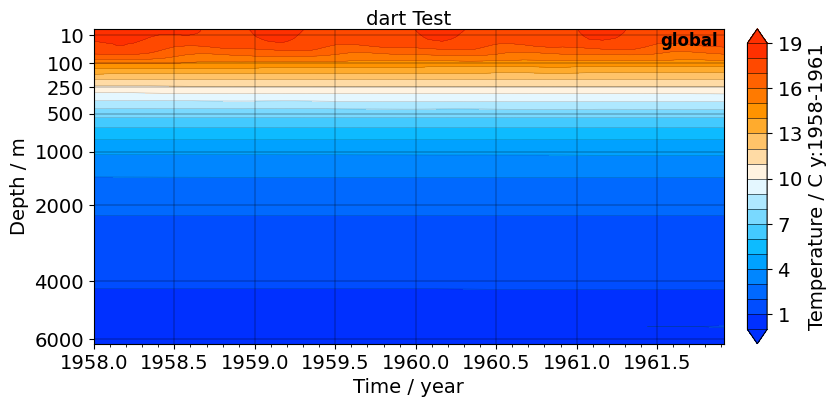

--> histo: cmin, cmax =  -1.6302398443222046 0.6546664237976074
{'cstr': 'blue2red', 'cnum': 15, 'chist': True, 'ctresh': 0.995, 'cnlab': 8, 'cmin': np.float64(-1.63), 'cmax': np.float64(0.65), 'cref': np.float64(-0.5), 'cmap': <matplotlib.colors.ListedColormap object at 0x154e68da3af0>, 'clevel': array([-1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1. , -0.9, -0.8, -0.7,
       -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, -0. ,  0.1,  0.2,  0.3,  0.4,
        0.5,  0.6,  0.7]), 'clab': array([-1.7, -1.3, -0.9, -0.5, -0.1,  0.3,  0.7])}
2.5 6175.0


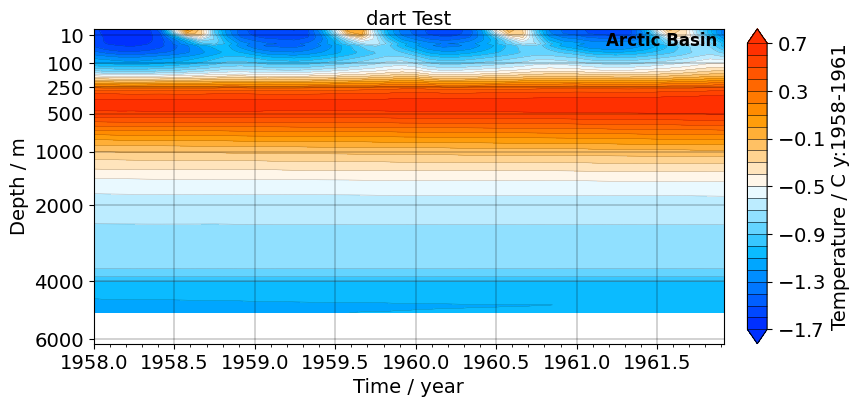

 --> elasped time to plot data: 0.03 min.


In [6]:
#___PLOT HOVM__________________________________________________________________________________________
ts = clock.time()
nbox, ndat = len(box), len(data_list)
if   ncol != None: 
    ncol0  = np.min([ncol,ndat])    
    nrow0  = np.ceil(ndat/ncol0).astype('int')
elif nrow != None: 
    nrow0  = np.min([nrow,ndat])    
    ncol0  = np.ceil(ndat/nrow0).astype('int')

for box_idx in range(nbox):
    svname = list(data_list[0][box_idx].data_vars)[0]
    slabel = data_list[0][box_idx][svname].attrs['str_lsave']
    sbox   = data_list[0][box_idx][svname].attrs['boxname'].replace(' ','_').lower()
    
    #__________________________________________________________________________________________________
    # do save filename path
    spath  = save_path
    sfpath = None
    if spath!=None: 
        sfpath=list()
        for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, 'hovm', sbox ,slabel, sfmt)) )
    if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality
   
    #__________________________________________________________________________________________________
    # do colorbar either single cbar or ref_cbar + anom_cbar
    if (ref_path != None) and do_reffig: cb_plt, cb_plt_single, cinfo0 = [1]+[2]*(nrow0*ncol0-1), False, [ref_cinfo.copy(), cinfo.copy()]
    else: cb_plt, cb_plt_single, cinfo0 = True, True, cinfo.copy() 
        
    #__________________________________________________________________________________________________    
    hfig, hax, hcb = tpv.plot_vslice(mesh, data_list, nrow=nrow0, ncol=ncol0, box_idx=box_idx, 
                                     cinfo=cinfo0, 
                                     do_plt=do_plt, plt_contb=plt_contb, plt_contf=plt_contf, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                     ax_opt=dict({'fig_sizefac':2.0, 'cb_plt':cb_plt, 'cb_plt_single':cb_plt_single, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                     cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(),
                                     do_save=sfpath, save_dpi=save_dpi )

print(' --> elasped time to plot data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))            

In [7]:
if do_papermill and do_parallel and client is not None: client.shutdown()